In [85]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import torch
import torchvision
import torchsample
import psycopg2
import random
import re
import time
import csv
import copy
import statsmodels
from functools import reduce 
from datetime import datetime
import shutil
import tempfile

from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import models
from torchvision import transforms
from torchsample import transforms as ts_transforms
from matplotlib import pyplot as plt
from PIL import Image
from geopy.distance import vincenty 
from scipy.ndimage import imread
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from math import sqrt
from zipfile import ZipFile
import pygrib

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score

from mpl_toolkits.mplot3d import Axes3D
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

# Connect to Database

## Configuration File

In [86]:
with open('../data/helpers/DBconfig.csv', mode='r') as infile:
    reader = csv.reader(infile)
    config = {rows[0]:rows[1] for rows in reader}

## Connection to DB

In [87]:
# Credentials fo AWS database
dsn_database = config['database']           # e.g. "compose"
dsn_hostname = "fogdb.cmse2tqlcvsl.eu-west-1.rds.amazonaws.com" # e.g.: "aws-us-east-1-portal.4.dblayer.com"
dsn_port = "9418"                 # e.g. 11101 
dsn_uid = config['\ufeffusername']       # e.g. "admin"
dsn_pwd = config ['password']     # e.g. "xxx"

try:
    conn_string = "host="+dsn_hostname+" port="+dsn_port+" dbname="+dsn_database+" user="+dsn_uid+" password="+dsn_pwd
    print("Connecting to database:\n{}\n".format(conn_string))
    conn=psycopg2.connect(conn_string)
except:
    print ("\nNo connection to the database could be established.")

# Create cursor
cursor = conn.cursor()

# Show database tables
print('Tables in fog database:')
cursor.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
cursor.fetchall()

Connecting to database:
host=fogdb.cmse2tqlcvsl.eu-west-1.rds.amazonaws.com port=9418 dbname=FOGDB user=KNMIFOG password=fog&mist123


No connection to the database could be established.


NameError: name 'conn' is not defined

# Acquire Target Data for Training (Subset)

## Distance DF

In [ ]:
distance_df = pd.read_csv('../data/helpers/distanceKNMIStationsToLocations.csv')

## Get All KNMI Images Data

In [ ]:
def get_path(filepath):
    '''
    Used for getting the right filepath.
    '''
    regex = re.compile(r'\d[/].*$')
    search = re.search(regex, filepath)
    jpg_name = search.group(0)[2:]

    # Second search for filepaths of highways
    regex2 = re.compile(r'[A]\d*-.*')
    search2 = re.search(regex2, jpg_name)
    
    if search2 != None:
        jpg_name = search2.group(0)
        return str(jpg_name)
    
    return jpg_name

cursor.execute("SELECT * FROM images WHERE day_phase = '1'")

# Fetch
img_df = pd.DataFrame(cursor.fetchall(), columns=['img_id', 'camera_id', 'datetime', 'filepath', 'day_phase'])
img_df['filepath'] = img_df['filepath'].apply(get_path, 1)

## Bind Stations to Locations

In [ ]:
# Fetch all the camera/location id pairs and put into df
cursor.execute("SELECT * FROM cameras")
df_cameras = pd.DataFrame(cursor.fetchall(), columns=['camera_id', 'location_id', 'cam_description', 'camera_name'])

# Merge image df with the cameras df and then with distance df
merged_image_cameras = pd.merge(img_df, df_cameras, on='camera_id')
merged_nearest = pd.merge(merged_image_cameras, distance_df, on='location_id')

## Get Visibility and Meteo Metrics

In [ ]:
cursor.execute("SELECT * FROM meteo_features_copy")

df_meteo_features = pd.DataFrame(cursor.fetchall(), columns=['key','MeteoStationLocationID', 'datetime', 
                                                             'wind_speed', 'rel_humidity', 'air_temp', 'dew_point',
                                                            'mor_vis'])

## Add Missing Meteorological Data

### Windspeed Data

In [ ]:
with open('../data/helpers/windspeed.csv', 'r') as file:
    csv_read = csv.reader(file)
    next(csv_read)
    
    c = 0
    for row in csv_read:
        if row[1] == '240_W_18Cm27':
            location_name = 'SCHIPHOL airport'
            meteo_id = 542
        elif row[1] == '344_W_06t':
            location_name = 'ROTTERDAM airport'
            meteo_id = 536
        elif row[1] == '380_W_04t':
            location_name = 'EELDE airport'
            meteo_id = 506
            
        date = row[0][:15].replace('_', '')
        
        if date[8:10] == '24':
            date = date[:8] + '00' + date[10:]

        datetime = datetime.strptime(date, '%Y%m%d%H%M%S')
        indices = df_meteo_features[(df_meteo_features['datetime'] == datetime) & 
                          (df_meteo_features['MeteoStationLocationID'] == meteo_id)].index

        for idx in indices:
            try:
                c += 1
                df_meteo_features.at[idx, 'wind_speed'] = row[2]
            except:
                print(location_name, datetime)
                
            if c % 10000 == 0:
                print('Added {} wind speed values'.format(c))         

### Temperature/Humidity Data

In [ ]:
with open('../data/helpers/temp_humidity.csv', 'r') as file:
    csv_read = csv.reader(file)
    next(csv_read)
    c = 0
    for row in csv_read:
        date = row[0][:15].replace('_', '')
        air_temp = row[2]
        rel_hum = row[4]
        meteo_id = 542
        
        if date[8:10] == '24':
            date = date[:8] + '00' + date[10:]
            
        datetime = datetime.strptime(date, '%Y%m%d%H%M%S')
        
        indices = df_meteo_features[(df_meteo_features['datetime'] == datetime) & 
                                    (df_meteo_features['MeteoStationLocationID'] == meteo_id)].index

        for idx in indices:

            try:
                c += 1
                df_meteo_features.at[idx, 'air_temp'] = air_temp
                df_meteo_features.at[idx, 'rel_humidity'] = rel_hum
            except:
                continue
                
            if c % 10000 == 0:
                print('Added {} temperature and humidity values'.format(c))    

In [96]:
loc_names = ['De Bilt (260_A_a)', 'Cabauw (348)', 'BEEK airport', 'EELDE airport', 'ROTTERDAM airport', 'SCHIPHOL airport']
KNMI = main_df[main_df['location_name'].isin(loc_names)]
KNMI_no = main_df[main_df['location_name'].isin(['De Bilt (260_A_a)', 'Cabauw (348)'])]
KNMI_no['datetime'].min()

Timestamp('2015-06-01 03:30:00')

## Bind Images to Visibility

In [ ]:
loc_names = ['De Bilt (260_A_a)', 'Cabauw (348)', 'BEEK airport', 'EELDE airport', 'ROTTERDAM airport', 'SCHIPHOL airport']

# Categorise images
def ordinal_visibility(mor_vis):
    if mor_vis > 1000:
        return 0
    elif mor_vis < 250:
        return 2
    elif mor_vis >= 250 and mor_vis <= 1000:
        return 1
    
# Here the meteo features of closest meteo station are linked to every camera
main_df = pd.merge(merged_nearest, df_meteo_features, on=['MeteoStationLocationID', 'datetime'])
main_df['visibility'] = main_df['mor_vis'].apply(ordinal_visibility, 1)

# Location to main df
cursor.execute("SELECT * FROM locations")
locations_df = pd.DataFrame(cursor.fetchall(), columns=['location_id', 'location_name', 'long', 'lat'])
main_df = pd.merge(locations_df, main_df, on='location_id')

# Make sure that meteo variables above 7500m distance are nan. We want to fill these with kriging
# main_df.loc[main_df.distanceInMeters > 7500, ['wind_speed', 'rel_humidity', 'air_temp', 'dew_point']] = np.nan
main_df.loc[~main_df.location_name.isin(loc_names), ['wind_speed', 'rel_humidity', 'air_temp', 'dew_point']] = np.nan

# # Distribution of labels
main_df['visibility'].value_counts()

## Bind Location Names to Location IDs

In [ ]:
# Drop unnecessary columns
retain_columns = ['location_id', 'long', 'lat', 'location_name', 'camera_id', 'datetime', 'filepath', 'MeteoStationLocationID', 
                 'camera_name', 'meteo_station_id', 'meteo_station_name', 'distanceInMeters', 'wind_speed',
                 'rel_humidity', 'air_temp', 'dew_point', 'mor_vis', 'visibility']

main_df = main_df[retain_columns]

### Change the File Path for Certain  Pictures

In [ ]:
def change_filepaths(filepath):
    '''
    Changes the filepaths of old de Bilt images and of Cabauw images.
    
    :param filepath: Either a de Bilt or Cabauw image filepath.
    '''
    if 'nobackup/users/' in filepath:
        return filepath[-29:]
    elif 'CABAUW' in filepath:
        return filepath[7:]
    else:
        return filepath
    
def change_cabauw(filepath):
    if 'CABAUW' in filepath:
        return filepath[7:]
    else:
        return filepath

main_df['filepath'] = main_df['filepath'].apply(change_filepaths, 1)

### Exclude NaN's

In [62]:
main_df = main_df[main_df['visibility'].notnull()]
main_df = main_df[main_df['rel_humidity'].notnull()]
main_df = main_df[main_df['wind_speed'].notnull()]
main_df= main_df[main_df['air_temp'].notnull()]

In [ ]:
def get_zipfile_path(date):

    original_hour = date[-2:]

    # Change the hour for getting right shit
    if int(original_hour) < 7:
        hour = '00'
    elif 6 < int(original_hour) < 13:
        hour = '06'
    elif 12 < int(original_hour) < 19:
        hour = '12'
    elif 18 < int(original_hour) < 24:
        hour = '18'

    zip_date = date[:-2]+hour

    # Get path to zipfile
    zipfile_name = 'HARM_{}_P1.zip'.format(zip_date)
    zip_path = '/Volumes/externe schijf/timWeatherModel/{}'.format(zipfile_name)
    
    return zip_path, zip_date

from tempfile import TemporaryDirectory

def open_grib(zip_path, zip_date, date):
    # Create temporary directory
    tDir = tempfile.mkdtemp('Harmonies')
    
    with TemporaryDirectory() as tmp_dir:
        
        # Open zipfile and get grib filepath
        archive = ZipFile(zip_path)
        grib_name = 'HA36_P1_{}00_0{}00_GB'.format(zip_date, date[-2:])

        # Extract right grib file from zip and bring to temporary directory
        extract_zip = archive.extract(grib_name, tmp_dir)
        gribfile = pygrib.open('{}/{}'.format(tmp_dir, grib_name))
    
    return gribfile

def get_latlon_idx(lats, longs, obs_lat, obs_lon):
    # Get the absolute distances between all grid points and observation point
    abslat = np.abs(lats - obs_lat)
    abslon = np.abs(lons - obs_lon)

    # Get the absolute distance for 
    lat_index = np.argmin(abslat)
    lon_index = np.argmin(abslon)

    c = np.maximum(abslon, abslat)
    latlon_idx = np.argmin(c)
    
    return latlon_idx

def calculate_dewpoint(RH, T):
    '''
    Calculates dewpoint give relative humidity and temperature. 0.08 is added at the end, because otherwise
    calculations would be inconsistent with dataframe values.
    '''
    RH = RH * 100
    DP = 243.04*(np.log(RH/100)+((17.625*T)/(243.04+T)))/(17.625-np.log(RH/100)-((17.625*T)/(243.04+T))) + 0.08
    return DP

def get_meteo_grids(grib):
    

    # Get variable values for date
    temps = grib.select(name='2 metre temperature')[0]
    rel_hums = grib.select(name='Relative humidity')[0]

    # Calculate the wind speed
    windcomponent_U = grib.select(name='10 metre U wind component')[0].values
    windcomponent_V = grib.select(name='10 metre V wind component')[0].values
    windspeeds = np.sqrt(windcomponent_U ** 2 + windcomponent_V **2)

    # Latitudes and longitudes are the same for every variable, because same grid is used
    lats, lons = temps.latlons()

    temps, rel_hums = temps.values, rel_hums.values
    
    return lats, lons, temps, rel_hums, windspeeds

In [ ]:
unique_dates = main_df['datetime'].unique()
num_dates = len(unique_dates)

for c, one_date in enumerate(unique_dates):

    # Get df for unique date and extract date
    date_df = main_df[main_df['datetime'] == one_date]
    
    # Convert date to string for getting zipfile
    t = pd.to_datetime(str(one_date)) 
    timestring = t.strftime('%Y%m%d%H')
    
    # Get the zipfile path and the right date for getting gribfile in ZIP
    zip_path, zip_date = get_zipfile_path(timestring)
    
    try:
        grib = open_grib(zip_path, zip_date, timestring)

        # Obtain grid point positions and meteo variables
        lats, lons, temps, rel_hums, windspeeds = get_meteo_grids(grib)

        for idx, row in date_df.iterrows():

            # Get the closest lat/lon index of grid
            obs_lat, obs_lon = row['lat'], row['long']
            closest_idx = get_latlon_idx(lats, lons, obs_lat, obs_lon)

            # Get the variable values
            temp, rel_hum, windspeed = temps.flat[closest_idx], rel_hums.flat[closest_idx], windspeeds.flat[closest_idx]
            temp = float(temp) - 272.15

            dew_point = calculate_dewpoint(rel_hum, temp)

            if np.isnan(row['air_temp']):
                main_df.at[idx, 'air_temp'] = temp
            if np.isnan(row['rel_humidity']):
                main_df.at[idx, 'rel_humidity'] = rel_hum
            if np.isnan(row['wind_speed']):
                main_df.at[idx, 'wind_speed'] = windspeed
            if np.isnan(row['dew_point']):
                main_df.at[idx, 'dew_point'] = dew_point

    except:
        print('Grib-file unavailable at index: {}, for date: {}'.format(c, timestring))
        continue

    if c % 100 == 0:
        print('Iterated over {} of {} unique dates'.format(c, num_dates))

### Pickle or Unpickle the Main Dataframe

In [73]:
q1 = input('do you want to pickle a new main_df dataframe? (y/n)')

if q1 == 'y':
    main_df.to_pickle('../data/semi-processed/meteo_standardize_df')
    print('succesfully pickled DF')
else:
    q2 = input('do you want to unpickle the current saved dataframe? (y/n)')
    if q2 == 'y':
        main_df = pd.read_pickle('../data/semi-processed/before_filling_meteo')
        print('succesfully unpickled DF')

do you want to pickle a new main_df dataframe? (y/n)n
do you want to unpickle the current saved dataframe? (y/n)y
succesfully unpickled DF


In [ ]:
KNMI_names = ['De Bilt (260_A_a)', 'Cabauw (348)', 'BEEK airport', 'EELDE airport', 'ROTTERDAM airport', 'SCHIPHOL airport']
meteo_variables = ['wind_speed', 'air_temp', 'rel_humidity', 'dew_point']

def distribution_meteo_variables(main_df):
    clip = {'wind_speed': (0, 12), 'air_temp': (-1000,1000), 'rel_humidity': (90, 120), 'dew_point':(-1000, 1000)}
    
    plot_df = main_df[main_df['location_name'].isin(KNMI_names)]
    fig = plt.figure(figsize=(15, 10))
    fig.tight_layout()
    
    # Boxplot for every variable
    for i, variable in enumerate(meteo_variables):
        
        if variable == 'rel_humidity':
            plot_df = plot_df[plot_df[variable] > 95]
    
        target_0 = plot_df.loc[plot_df['visibility'] == 0]
        target_1 = plot_df.loc[plot_df['visibility'] == 1]
        target_2 = plot_df.loc[plot_df['visibility'] == 2]
        
        # Make-up
        fig.add_subplot(2, 2, i + 1)
        plt.title('Density plot of {}'.format(variable))
        plt.ylabel('Density')
        
        sns.distplot(target_0[variable], hist=False, kde=True, kde_kws = {'linewidth':3, 'clip': clip[variable], 'shade':True}, label='no fog')
        sns.distplot(target_1[variable], hist=False, kde=True, kde_kws = {'linewidth':3,'clip': clip[variable], 'shade':True}, label='light fog')
        sns.distplot(target_2[variable], hist=False, kde=True, kde_kws = {'linewidth':3,'clip': clip[variable], 'shade':True},label='dense fog')
    
    plt.show()
    
boxplot_meteo_variables(main_df)

## Close Database Connection

In [ ]:
conn.close()

## Image Parameters

In [15]:
IMG_SIZE = 100
CHANNELS = 3

## Load and Manipulate Test Data (Manually Labeled)

### Data Loading

In [79]:
LABELED_DIR = '/Volumes/TIMKNMI/KNMIPictures/RWS/'

# Used for storing filename:label pairs
image_list_test = []
target_list_test = []
filepath_list_test = []
meteo_list_test = []

# This opens all labeled files and finds the corresponding pictures and labels
with open(LABELED_DIR + 'TestImages.txt') as filestream:
    c = 0
    for row in filestream:
        row = row.strip().split(',')
        filename = row[0]
        label = row[1]
        
        datapoint_df = main_df[main_df['filepath'] == filename]
        meteo = datapoint_df[['wind_speed', 'rel_humidity', 'air_temp', 'dew_point']]
#         print(filename)
        if len(np.asarray(meteo)) > 0:
            print(meteo)
            # Regex necessary elements
            highway = re.search(r'A\d*', filename).group(0)
            ID = re.search(r'ID\d*', filename).group(0)
            HM = re.search(r'HM\d*', filename).group(0)
            year_month = re.search(r'_\d*_', filename).group(0)[1:7]

            path = '{}{}/{}/{}/{}/{}'.format(LABELED_DIR, highway, HM, ID, year_month, filename)

            img = Image.open(path)
            img = img.resize((IMG_SIZE, IMG_SIZE))

            image_list_test.append(np.asarray(img))
            target_list_test.append(np.asarray(label))
            filepath_list_test.append(np.asarray(path))
            meteo_list_test.append(np.asarray(meteo))

            img.close()
        else:
            print(filename)
            

test_features, test_targets, test_filepaths, test_meteo = np.asarray(image_list_test), np.asarray(target_list_test).astype(int), np.asarray(filepath_list_test), np.asarray(meteo_list_test)
# test_meteo = test_meteo.reshape(len(test_meteo), 4)

A1-HM47-ID13970_20170630_0802.jpg
A1-HM47-ID13970_20170630_0832.jpg
A1-HM47-ID13970_20170630_0942.jpg
A1-HM47-ID13970_20170630_1102.jpg
A1-HM47-ID13970_20170630_1452.jpg
A1-HM47-ID13970_20170630_1552.jpg
        wind_speed  rel_humidity  air_temp  dew_point
835970         NaN           NaN       NaN        NaN
        wind_speed  rel_humidity  air_temp  dew_point
837103         NaN           NaN       NaN        NaN
A15-HM801-ID12047_20170801_0932.jpg
A15-HM801-ID12047_20170803_1032.jpg
A15-HM801-ID12047_20170805_1132.jpg
A15-HM801-ID12047_20170807_1232.jpg
A15-HM801-ID12047_20170809_1332.jpg
A15-HM801-ID12047_20170811_1432.jpg
A15-HM801-ID12047_20170813_1532.jpg
A15-HM801-ID12047_20170815_1631.jpg
A15-HM801-ID12047_20170817_1001.jpg
A15-HM801-ID12047_20170819_1101.jpg
A15-HM801-ID12047_20170821_1201.jpg
A2-HM914-ID13472_20170901_0931.jpg
A2-HM914-ID13472_20170903_1031.jpg
        wind_speed  rel_humidity  air_temp  dew_point
352536         NaN           NaN       NaN        NaN
      

        wind_speed  rel_humidity  air_temp  dew_point
284621         NaN           NaN       NaN        NaN
        wind_speed  rel_humidity  air_temp  dew_point
284594         NaN           NaN       NaN        NaN
        wind_speed  rel_humidity  air_temp  dew_point
284666         NaN           NaN       NaN        NaN
        wind_speed  rel_humidity  air_temp  dew_point
284607         NaN           NaN       NaN        NaN
A2-HM776-ID10915_20170701_0802.jpg
A2-HM776-ID10915_20170702_0552.jpg
A2-HM776-ID10915_20170705_1402.jpg
A2-HM776-ID10915_20170706_0352.jpg
A2-HM776-ID10915_20170706_1502.jpg
A2-HM776-ID10915_20170708_1512.jpg
A2-HM776-ID10915_20170711_1502.jpg
A2-HM776-ID10915_20170714_0322.jpg
        wind_speed  rel_humidity  air_temp  dew_point
303676         NaN           NaN       NaN        NaN
A2-HM778-ID10916_20170803_1212.jpg
A2-HM778-ID10916_20170803_1722.jpg
A2-HM778-ID10916_20170804_0642.jpg
A2-HM778-ID10916_20170808_1852.jpg
A2-HM778-ID10916_20170809_1752.jpg
A2-HM

        wind_speed  rel_humidity  air_temp  dew_point
369475         NaN           NaN       NaN        NaN
        wind_speed  rel_humidity  air_temp  dew_point
369560         NaN           NaN       NaN        NaN
        wind_speed  rel_humidity  air_temp  dew_point
369606         NaN           NaN       NaN        NaN
        wind_speed  rel_humidity  air_temp  dew_point
369713         NaN           NaN       NaN        NaN
        wind_speed  rel_humidity  air_temp  dew_point
369888         NaN           NaN       NaN        NaN
        wind_speed  rel_humidity  air_temp  dew_point
380087         NaN           NaN       NaN        NaN
        wind_speed  rel_humidity  air_temp  dew_point
382700         NaN           NaN       NaN        NaN
        wind_speed  rel_humidity  air_temp  dew_point
382956         NaN           NaN       NaN        NaN
        wind_speed  rel_humidity  air_temp  dew_point
382980         NaN           NaN       NaN        NaN
        wind_speed  rel_humi

        wind_speed  rel_humidity  air_temp  dew_point
859851         NaN           NaN       NaN        NaN
A1-HM55-ID12956_20171221_0750.jpg
        wind_speed  rel_humidity  air_temp  dew_point
868302         NaN           NaN       NaN        NaN
        wind_speed  rel_humidity  air_temp  dew_point
868768         NaN           NaN       NaN        NaN
        wind_speed  rel_humidity  air_temp  dew_point
868689         NaN           NaN       NaN        NaN
        wind_speed  rel_humidity  air_temp  dew_point
868747         NaN           NaN       NaN        NaN
        wind_speed  rel_humidity  air_temp  dew_point
868717         NaN           NaN       NaN        NaN
A1-HM57-ID12957_20171202_0730.jpg
        wind_speed  rel_humidity  air_temp  dew_point
875769         NaN           NaN       NaN        NaN
        wind_speed  rel_humidity  air_temp  dew_point
875600         NaN           NaN       NaN        NaN
        wind_speed  rel_humidity  air_temp  dew_point
875485        

         wind_speed  rel_humidity  air_temp  dew_point
1016302         NaN           NaN       NaN        NaN
         wind_speed  rel_humidity  air_temp  dew_point
1016337         NaN           NaN       NaN        NaN
         wind_speed  rel_humidity  air_temp  dew_point
1016303         NaN           NaN       NaN        NaN
         wind_speed  rel_humidity  air_temp  dew_point
1016319         NaN           NaN       NaN        NaN
         wind_speed  rel_humidity  air_temp  dew_point
1016337         NaN           NaN       NaN        NaN
         wind_speed  rel_humidity  air_temp  dew_point
1017123         NaN           NaN       NaN        NaN
         wind_speed  rel_humidity  air_temp  dew_point
1017091         NaN           NaN       NaN        NaN
A5-HM121-ID13777_20170801_1232.jpg
A5-HM121-ID13777_20170802_1822.jpg
        wind_speed  rel_humidity  air_temp  dew_point
393689         NaN           NaN       NaN        NaN
        wind_speed  rel_humidity  air_temp  dew_poin

         wind_speed  rel_humidity  air_temp  dew_point
1198661         NaN           NaN       NaN        NaN
         wind_speed  rel_humidity  air_temp  dew_point
1198763         NaN           NaN       NaN        NaN
         wind_speed  rel_humidity  air_temp  dew_point
1198627         NaN           NaN       NaN        NaN
         wind_speed  rel_humidity  air_temp  dew_point
1198599         NaN           NaN       NaN        NaN
         wind_speed  rel_humidity  air_temp  dew_point
1199218         NaN           NaN       NaN        NaN
         wind_speed  rel_humidity  air_temp  dew_point
1199515         NaN           NaN       NaN        NaN
         wind_speed  rel_humidity  air_temp  dew_point
1206107         NaN           NaN       NaN        NaN
         wind_speed  rel_humidity  air_temp  dew_point
1206175         NaN           NaN       NaN        NaN
         wind_speed  rel_humidity  air_temp  dew_point
1206125         NaN           NaN       NaN        NaN
         w

         wind_speed  rel_humidity  air_temp  dew_point
1287442         NaN           NaN       NaN        NaN
         wind_speed  rel_humidity  air_temp  dew_point
1287456         NaN           NaN       NaN        NaN
         wind_speed  rel_humidity  air_temp  dew_point
1287664         NaN           NaN       NaN        NaN
A15-HM791-ID12042_20170801_1002.jpg
A15-HM791-ID12042_20170804_1242.jpg
         wind_speed  rel_humidity  air_temp  dew_point
1294813         NaN           NaN       NaN        NaN
         wind_speed  rel_humidity  air_temp  dew_point
1294865         NaN           NaN       NaN        NaN
         wind_speed  rel_humidity  air_temp  dew_point
1294818         NaN           NaN       NaN        NaN
A15-HM793-ID12043_20171220_1141.jpg
A15-HM793-ID12043_20170801_1412.jpg
A15-HM793-ID12043_20170811_1512.jpg
A15-HM795-ID12044_20171201_0928.jpg
         wind_speed  rel_humidity  air_temp  dew_point
1302032         NaN           NaN       NaN        NaN
         wind_

        wind_speed  rel_humidity  air_temp  dew_point
471340         NaN           NaN       NaN        NaN
        wind_speed  rel_humidity  air_temp  dew_point
471433         NaN           NaN       NaN        NaN
        wind_speed  rel_humidity  air_temp  dew_point
485350         NaN           NaN       NaN        NaN
        wind_speed  rel_humidity  air_temp  dew_point
485333         NaN           NaN       NaN        NaN
        wind_speed  rel_humidity  air_temp  dew_point
485409         NaN           NaN       NaN        NaN
        wind_speed  rel_humidity  air_temp  dew_point
480191         NaN           NaN       NaN        NaN
        wind_speed  rel_humidity  air_temp  dew_point
480196         NaN           NaN       NaN        NaN
        wind_speed  rel_humidity  air_temp  dew_point
480270         NaN           NaN       NaN        NaN
A28-HM2000-ID13516_20171202_0720.jpg
        wind_speed  rel_humidity  air_temp  dew_point
494283         NaN           NaN       NaN   

ValueError: invalid literal for int() with base 10: '2 ???'

In [ ]:
light = np.where(test_targets == 1)[0]
dense = np.where(test_targets == 2)[0]

for idx in light:
    print(test_filepaths[idx])
    img = test_features[idx]
    plt.imshow(img)
    plt.show()

## Load KNMI Train Data to Numpy Arrays

### Get Numpy Arrays

In [ ]:
KNMI_DIR = '/Volumes/TIMPP/KNMIPictures/'

image_list = []
target_list = []
filepath_list = []
meteo_list = []

KNMI_names = ['De Bilt (260_A_a)', 'Cabauw (348)', 'BEEK airport', 'EELDE airport', 'ROTTERDAM airport', 'SCHIPHOL airport']
KNMI_df = main_df[main_df['location_name'].isin(KNMI_names)]

for c, (index, row) in enumerate(KNMI_df.iterrows()):
    folder = row['filepath'].split('-')[0]
    folder = folder.split('_')[0]
    camera = row['camera_name']
    year_month = row['datetime'].strftime("%Y%m")  
    file = row['filepath']
    meteo = row[['wind_speed', 'rel_humidity', 'air_temp', 'dew_point']]
    
    filepath = '/Volumes/TIMPP/KNMIPictures/{}/{}/{}/{}'.format(folder, camera, year_month, file)

    try:
        img = Image.open(filepath)
        img = img.resize((IMG_SIZE, IMG_SIZE))
        image_list.append(np.asarray(img))
        img.close()

        # Get target, append to target list
        target = main_df[main_df['filepath'] == file]['visibility']
        target_list.append(target.iloc[0])
        filepath_list.append(filepath)
        meteo_list.append(meteo)

    # Catch erroneous files and continue if caught
    except:
        print('Could not load image: {}'.format(file))
        continue
    
    # Print number of loaded images every 500 iterations
    if c % 500 == 0:
        print('Number of df rows iterated: {} of {}'.format(c, len(KNMI_df)))

KNMI_images, KNMI_targets, KNMI_filepaths, KNMI_meteo = np.asarray(image_list), np.asarray(target_list), np.asarray(filepath_list), np.asarray(meteo_list)    

### Ommit Labels and Change Labels KNMI 

In [ ]:
# Get indices to delete from KNMI numpy arrays
del_knmi_idx = [i for i, v in enumerate(KNMI_filepaths) if 'BSRN-1' in v or 'Meetterrein_201606' in v or 'Meetterrein_201607' in v
            or 'Meetterrein_201608' in v]

# Ommit bad images from numpy arrays
KNMI_targets = np.delete(KNMI_targets, del_knmi_idx, 0)
KNMI_images = np.delete(KNMI_images, del_knmi_idx, 0)
KNMI_filepaths = np.delete(KNMI_filepaths, del_knmi_idx, 0)
KNMI_meteo = np.delete(KNMI_meteo, del_knmi_idx, 0)

# Change targets of wrongly labeled images
with open('../data/helpers/knmichangelabels') as file:
    for row in file:
        path, target = row.split(',')
        path_idx = np.where(KNMI_filepaths == path.strip("'"))
        KNMI_targets[path_idx] = target

In [ ]:
KNMI_targets = np.load('../data/processed/KNMI_train_targets.npy')
KNMI_images = np.load('../data/processed/KNMI_train_images.npy')
KNMI_filepaths = np.load('../data/processed/KNMI_train_filepaths.npy')
KNMI_meteo = np.load('../data/processed/KNMI_train_meteo.npy')

## Load Highway Train Data to Numpy Arrays

### Create Highway DF

In [ ]:
schiphol_df = main_df[main_df['MeteoStationLocationID'] == 542]
schiphol_highways = schiphol_df[schiphol_df['location_name']!= 'SCHIPHOL airport']
eelde_df = main_df[main_df['MeteoStationLocationID'] == 506]
eelde_highways = eelde_df[eelde_df['location_name'] != 'EELDE airport']
highway_df = pd.concat([eelde_highways, schiphol_highways])
highway_df = highway_df[highway_df['distanceInMeters'] < 7500]

### Transform Data to Numpy Arrays

In [ ]:
image_list = []
target_list = []
filepath_list = []
meteo_list = []
count = 1

for index, row in highway_df.iterrows():
    location = row['location_name'].split('-')
    year_month = row['datetime'].strftime("%Y%m")
    file = row['filepath']
    meteo = row[['wind_speed', 'rel_humidity', 'air_temp', 'dew_point']]
    filepath = '/Volumes/TIMKNMI/KNMIPictures/UnlabeledRWS/{}/{}/{}/{}/{}'.format(location[0], location[1], location[2],
                                                                                 year_month, file)
    try:
        img = Image.open(filepath)
        img = img.resize((IMG_SIZE, IMG_SIZE))
        image_list.append(np.asarray(img))
        img.close()

        # Get target, append to target list
        target = main_df[main_df['filepath'] == file]['visibility']
        target_list.append(target.iloc[0])
        filepath_list.append(filepath)
        meteo_list.append(meteo)
        count += 1

        # Print number of loaded images every 500 iterations
        if count % 500 == 0:
            print('Number of images loaded: {}'.format(count))

    #Catch erroneous files and continue if caught
    except:
        print('Could not load image: {}'.format(file))
        continue
    
highway_images, highway_targets, highway_filepaths, highway_meteo = np.asarray(image_list), np.asarray(target_list), np.asarray(filepath_list), np.asarray(meteo_list)

In [97]:
highway_images = np.load('/Volumes/TIMPP/UnusedKNMI/numpyfiles/meteo/valtestinterpolated/highway/highway_images_allIDW.npy')
highway_targets = np.load('/Volumes/TIMPP/UnusedKNMI/numpyfiles/meteo/valtestinterpolated/highway/highway_targets_allIDW.npy')
highway_filepaths = np.load('/Volumes/TIMPP/UnusedKNMI/numpyfiles/meteo/valtestinterpolated/highway/highway_filepaths_allIDW.npy')
highway_meteo = np.load('/Volumes/TIMPP/UnusedKNMI/numpyfiles/meteo/valtestinterpolated/highway/highway_meteo_allIDW.npy')

### Ommit Labels and Change Labels Highway

#### Change

In [ ]:
with open('../data/helpers/trainhighwaylabels') as file:
    for row in file:
        path, target = row.split(',')
        path_idx = np.where(highway_filepaths == path.strip("'"))
        highway_targets[path_idx] = target
    file.close()

In [66]:
meteo_df = main_df[['wind_speed', 'rel_humidity', 'air_temp', 'dew_point']]

#### Ommit

In [ ]:
with open('../data/helpers/ommitancehighway') as file:
    indices = []
    for row in file:
        row = " ".join(row.split())
        path = row.strip("'")
        path_idx = np.where(highway_filepaths == row.strip("'"))
        indices.append(path_idx[0][0])
        
highway_targets = np.delete(highway_targets, indices, 0)
highway_images = np.delete(highway_images, indices, 0)
highway_filepaths = np.delete(highway_filepaths, indices, 0)
highway_meteo = np.delete(highway_meteo, indices, 0)

In [ ]:
np.save('../data/processed/highway_targets_allIDW.npy', highway_targets)
np.save('../data/processed/highway_images_allIDW.npy', highway_images)
np.save('../data/processed/highway_filepaths_allIDW.npy', highway_filepaths)
np.save('../data/processed/highway_meteo_allIDW.npy', highway_meteo)

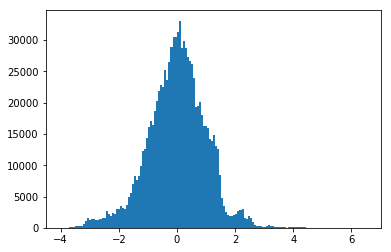

In [43]:
test_images = np.load('/Volumes/TIMPP/UnusedKNMI/numpyfiles/meteo/valtestinterpolated/highway/highway_images_allIDW.npy')
highway_targets = np.load('/Volumes/TIMPP/UnusedKNMI/numpyfiles/meteo/valtestinterpolated/highway/highway_targets_allIDW.npy')
highway_filepaths = np.load('/Volumes/TIMPP/UnusedKNMI/numpyfiles/meteo/valtestinterpolated/highway/highway_filepaths_allIDW.npy')
highway_meteo = np.load('/Volumes/TIMPP/UnusedKNMI/numpyfiles/meteo/valtestinterpolated/highway/highway_meteo_allIDW.npy')

In [ ]:
concat = np.concatenate([meteo_df, test_meteo])
standardize_df = standardize_df.dropna(axis=0)
std_scale = preprocessing.StandardScaler().fit(standardize_df[[0, 1, 2, 3]])
highway_meteo = std_scale.transform(standardize_df[[0, 1, 2, 3]])
test_meteo = highway_meteo[-len(test_meteo):]

## Standardize Meteo Variables

In [ ]:
standardize_df = pd.DataFrame(highway_meteo, columns=[0, 1, 2, 3])
standardize_df = standardize_df.dropna(axis=0)
std_scale = preprocessing.StandardScaler().fit(standardize_df[[0, 1, 2, 3]])
highway_meteo = std_scale.transform(standardize_df[[0, 1, 2, 3]])

## Data Splits
Only highway data is split. KNMI data will be used for training as a whole and tested on the highway validation dataset.

### Validation Data
5 of the labelled highway cameras will be used for validation of both the highway train dataset and KNMI train dataset.

In [ ]:
camera_list = ['A28/HM1893', 'A4/HM103', 'A5/HM86', 'A9/HM302', 'A28/HM1966']

val_idx = [i for camera in camera_list for i, v in enumerate(highway_filepaths) if camera in v]
X_validation, y_validation = highway_images[val_idx], highway_targets[val_idx].astype(int)
paths_validation, meteo_validation = highway_filepaths[val_idx], highway_meteo[val_idx]

### Highway Train Data
Highway images that are used for the validation data are deleted. What remains is the highway train data.

In [ ]:
X_train_highway = np.delete(highway_images, val_idx, 0)
y_train_highway = np.delete(highway_targets, val_idx, 0).astype(int)
paths_train_highway = np.delete(highway_filepaths, val_idx, 0)
meteo_train_highway = np.delete(highway_meteo, val_idx, 0)

In [ ]:
# Get the class proportions
class_counts = np.bincount(y_train_highway.astype(int))
total = len(y_train_highway)
proportion_0 = class_counts[0] / total
proportion_1 = class_counts[1] / total
proportion_2 = class_counts[2] / total

print('Class percentages:\nNo fog: {:.2f}%\nFog: {:.2f}%\nDense fog: {:.2f}%'.format(proportion_0 * 100,
                                                                              proportion_1 * 100, proportion_2 * 100))
print(class_counts)

## Write Numpy Arrays
Write the images, targets and filepaths to numpy arrays. These will be used for training and testing of the models.

### KNMI 

In [ ]:
np.save('../data/processed/knmi_train_images_no_change.npy', KNMI_images)
np.save('../data/processed/knmi_train_targets_no_change.npy', KNMI_targets)
np.save('../data/processed/knmi_train_filepaths_no_change.npy', KNMI_filepaths)
np.save('../data/processed/knmi_train_meteo_no_change.npy', KNMI_meteo)

### Highway Training

In [ ]:
np.save('../data/processed/highway_train_images1.npy', X_train_highway)
np.save('../data/processed/highway_train_targets1.npy', y_train_highway)
np.save('../data/processed/highway_train_filepaths1.npy', paths_train_highway)
np.save('../data/processed/highway_train_meteo1.npy', meteo_train_highway)

### Highway Validation

In [ ]:
np.save('../data/processed/highway_val_images.npy', X_validation)
np.save('../data/processed/highway_val_targets.npy', y_validation)
np.save('../data/processed/highway_val_filepaths.npy', paths_validation)
np.save('../data/processed/highway_val_meteo.npy', meteo_validation)

### Highway Test

In [ ]:
np.save('../data/processed/test_images_meteo.npy', test_features)
np.save('../data/processed/test_targets_meteo.npy', test_targets)
np.save('../data/processed/test_filepaths_meteo.npy', test_filepaths)
np.save('../data/processed/test_meteo_meteo.npy', test_meteo)

## PCA
Optional to do a PCA for any of the datasets. It's advisable to only use a part of the no fog class data, because otherwise it's too computationally heavy.

In [4]:
highway_images = np.load('/Volumes/TIMPP/UnusedKNMI/numpyfiles/meteo/testinterpolated/highway/change/highway_images.npy')
highway_targets = np.load('/Volumes/TIMPP/UnusedKNMI/numpyfiles/meteo/testinterpolated/highway/change/highway_targets.npy')
highway_filepaths = np.load('/Volumes/TIMPP/UnusedKNMI/numpyfiles/meteo/testinterpolated/highway/change/highway_filepaths.npy')
highway_meteo = np.load('/Volumes/TIMPP/UnusedKNMI/numpyfiles/meteo/testinterpolated/highway/change/highway_meteo.npy')

In [23]:
nofog_idx = np.where(highway_targets == 0)
light_idx = np.where(highway_targets == 1)
dense_idx = np.where(highway_targets == 2)
nofog_idx = np.random.choice(nofog_idx[0], 10000)

# Select images and targets
nofog_img, nofog_target = highway_images[nofog_idx], highway_targets[nofog_idx]
light_img, light_target = highway_images[light_idx], highway_targets[light_idx]
dense_img, dense_target = highway_images[dense_idx], highway_targets[dense_idx]

In [24]:
PCA_img = np.concatenate((nofog_img, light_img, dense_img))
PCA_targets = np.concatenate((nofog_target, light_target, dense_target))

### Main PCA

In [28]:
from sklearn.manifold import TSNE
def run_PCA(X_data, y_data):
    '''
    Gets 2-dimensional principal components for pixel data
    
    :param X_data: Pixel values of images
    :param y_data: Corresponding target values of images
    '''
    
    # Define and transform data
    pca = PCA(n_components=2)
    principal_components= pca.fit_transform(X_data.flatten().reshape(len(X_data), IMG_SIZE * IMG_SIZE * CHANNELS))
    
    # Create DF of PCA's and targets 
    PCA_df = pd.DataFrame(data=principal_components, columns=['PCA1', 'PCA2'])
    target_df = pd.DataFrame(data=y_data, columns=['target'])
    PCA_df = pd.concat([PCA_df, target_df['target']], axis=1)
    
    return PCA_df

def run_TSNE(X_data, y_data):
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    p_c = tsne.fit_transform(X_data.flatten().reshape(len(X_data), IMG_SIZE * IMG_SIZE * CHANNELS))
    
    tsne_df = pd.DataFrame(data=p_c, columns=['PCA1', 'PCA2'])
    target_df = pd.DataFrame(data=y_data, columns=['target'])
    tsne_df = pd.concat([tsne_df, target_df['target']], axis=1)
    
    return tsne_df

def plot_PCA(PCA_df):
    '''
    This plots a PCA dataframe created with the run_PCA function
    
    :param PCA_df: PCA dataframe
    
    '''
    # Create figure
    fig = plt.figure(figsize= (8,8))
    ax = fig.add_subplot(111)
    ax.set_xlabel("PCA1")
    ax.set_ylabel("PCA2")
    targets = [0, 1, 2]
    class_names= ['Clear', 'Light Fog', 'Dense Fog']
    colors = ['r', 'g', 'b']
                                            
    for target, color in zip(targets, colors):
        indicesToKeep = PCA_df['target'] == target
        ax.scatter(PCA_df.loc[indicesToKeep, 'PCA1'],
                   PCA_df.loc[indicesToKeep, 'PCA2'],
                   c = color,
                   s = 50)

        ax.legend(class_names)
        ax.grid()

### Example PCA Analysis
PCA on a part of the highway dataset

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 14604 samples in 44.494s...
[t-SNE] Computed neighbors for 14604 samples in 9213.263s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14604
[t-SNE] Computed conditional probabilities for sample 2000 / 14604
[t-SNE] Computed conditional probabilities for sample 3000 / 14604
[t-SNE] Computed conditional probabilities for sample 4000 / 14604
[t-SNE] Computed conditional probabilities for sample 5000 / 14604
[t-SNE] Computed conditional probabilities for sample 6000 / 14604
[t-SNE] Computed conditional probabilities for sample 7000 / 14604
[t-SNE] Computed conditional probabilities for sample 8000 / 14604
[t-SNE] Computed conditional probabilities for sample 9000 / 14604
[t-SNE] Computed conditional probabilities for sample 10000 / 14604
[t-SNE] Computed conditional probabilities for sample 11000 / 14604
[t-SNE] Computed conditional probabilities for sample 12000 / 14604
[t-SNE] Computed conditional probabilities fo

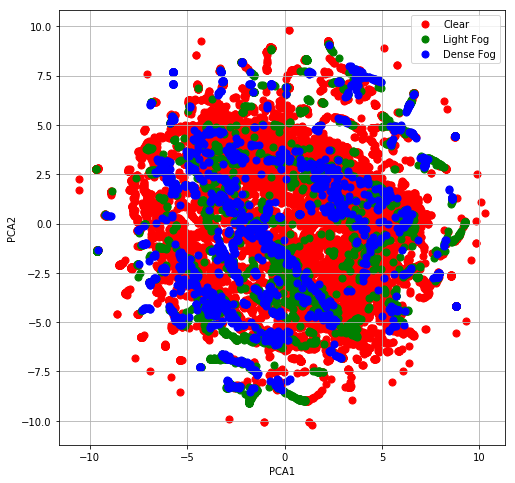

In [29]:
# Run PCA
PCA_df = run_TSNE(PCA_img, PCA_targets)
plot_PCA(PCA_df)